In [1]:
from google.colab import drive 
drive.mount('/content/myfiles')

MessageError: ignored

In [2]:
%cd "/content/myfiles/MyDrive/Politechnika/GSN/gsn-2022z-hand-segmentation"
!pwd

[Errno 2] No such file or directory: '/content/myfiles/MyDrive/Politechnika/GSN/gsn-2022z-hand-segmentation'
/content
/content


In [ ]:
!git fetch

In [ ]:
!git add skinny_no_i_d.ipynb

In [ ]:
!git commit -m "Begin implementation of learning procedur"

[main b759318] Small corrections to the model
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite skinny_no_i_d.ipynb (89%)


In [ ]:
!git push

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.38 KiB | 282.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
To https://gitlab-stud.elka.pw.edu.pl/mmarcin5/gsn-2022z-hand-segmentation.git
   1feaa1c..b759318  main -> main


In [ ]:
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image
from PIL import Image
import torchvision.transforms as transforms
import torch

# dataloader
class SkinDataset(Dataset):
    def __init__(self, description_file, out_size, transform_image=None, 
                 target_transform=None):
        self.images_file = pd.read_csv(description_file)
        self.transform_image = transform_image
        self.target_transform = target_transform
        self.size = out_size
        self.resize = transforms.Resize(self.size)

    def __len__(self):
        return len(self.images_file)

    def __getitem__(self, idx):
        img_path = self.images_file.iloc[idx, 0]
        image = read_image(img_path)
        w = image.size()[1]
        h = image.size()[2]

        if(w > h):
          diff = w - h
          pad = (0, diff, 0, 0)
        else:
          diff = h - w
          pad = (0, 0, 0, diff)
        if self.transform_image:
            image = self.transform_image(image.to(torch.float64))
        image = torch.nn.functional.pad(image, pad, mode='constant', value=1)
        image = self.resize(image)

        label_path = self.images_file.iloc[idx, 1]
        label = Image.open(label_path)
        if self.target_transform:
            label = self.target_transform(label)
        label = torch.nn.functional.pad(label, pad, mode='constant', value=1)
        label = self.resize(label)
        label_one_hot = torch.nn.functional.one_hot(label.to(torch.int64), 2).transpose(1, 3).squeeze().permute(0, 2, 1)


        return image, label_one_hot


In [ ]:
padding_mode = 'same'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# first part - double convolution
class InitConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.sequential_stack = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels)
    )
  
  def forward(self, x):
    return self.sequential_stack(x)

In [ ]:
# downscaling - double convolution with max pooling
class ConvDown(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.sequential_stack = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels)
    )
  
  def forward(self, x):
    return self.sequential_stack(x)

In [ ]:
# upscaling - double convolution with convolution transpose and concatenation
class DeconvUp(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    mid_channels = out_channels // 2

    self.sequential_stack = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ConvTranspose2d(in_channels=out_channels, out_channels=mid_channels, 
                           stride=2, kernel_size=3),
        nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x1, x2):
    x1 = self.sequential_stack(x1)
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
    return torch.cat([x2, x1], dim=1)

In [ ]:
# final module with several convolution layers finished with sigmoid
class FinalConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(FinalConv, self).__init__()

    mid_channels = in_channels // 2

    self.sequential_stack = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels // 2, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=mid_channels // 2, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.sequential_stack(x)

In [ ]:
class AdditionalLayers(nn.Module):
  def __init__(self):
    super().__init__()

    self.sequential_stack = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2)
    )
  
  def forward(self, x):
    return self.sequential_stack(x)

In [ ]:
# Skinny architecture variant without inception modules and dense blocks
class Skinny(nn.Module):
  def __init__(self, n_channels, n_classes):
    super(Skinny, self).__init__()

    self.n_channels = n_channels
    self.n_classes = n_classes

    self.init = (InitConv(self.n_channels, 15))

    self.conv_down1 = (ConvDown(15, 30))
    self.conv_down2 = (ConvDown(30, 60))
    self.conv_down3 = (ConvDown(60, 120))
    self.conv_down4 = (ConvDown(120, 240))

    self.additional = (AdditionalLayers())

    self.deconv_up1 = (DeconvUp(240, 480))
    self.deconv_up2 = (DeconvUp(480, 240))
    self.deconv_up3 = (DeconvUp(240, 120))
    self.deconv_up4 = (DeconvUp(120, 60))
    self.deconv_up5 = (DeconvUp(60, 30))

    self.final = (FinalConv(30, n_classes))
  
  def forward(self, x):
    x1 = self.init(x)
    x2 = self.conv_down1(x1)
    x3 = self.conv_down2(x2)
    x4 = self.conv_down3(x3)
    x5 = self.conv_down4(x4)
    x6 = self.additional(x5)

    x7 = self.deconv_up1(x6, x5)
    x8 = self.deconv_up2(x7, x4)
    x9 = self.deconv_up3(x8, x3)
    x10 = self.deconv_up4(x9, x2)
    x11 = self.deconv_up5(x10, x1)
    
    output = self.final(x11)

    return output

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 30.2 MB/s 


In [ ]:
from torchmetrics import JaccardIndex

iou = JaccardIndex(num_classes=2, task="binary").to(device)

In [ ]:
def DiceBCELoss(x, y):
  x = x.flatten()
  y = y.flatten()
        
  intersection = (x * y).sum()                            
  dice_loss = 1 - (2.*intersection)/(x.sum() + y.sum())  
  BCE = F.binary_cross_entropy(x, y)
  loss = (BCE + dice_loss) / 2
        
  return loss

In [ ]:
import numpy as np

mean = torch.tensor([63.4062, 57.8478, 55.2177], dtype=torch.float64)
std = torch.tensor([52.1825, 46.3412, 44.8947], dtype=torch.float64)

transform_label = transforms.Compose([transforms.ToTensor()])
transform_image = transforms.Compose([transforms.Normalize(mean, std)])

data_1 = SkinDataset("data_type1.csv", 512, transform_image, transform_label)
data_2a = SkinDataset("data_type2a.csv", 512, transform_image, transform_label)

train_percent = 0.8
train_len_1 = int(np.floor(train_percent * len(data_1)))
train_len_2a = int(np.floor(train_percent * len(data_2a)))

train_1, test_1 = torch.utils.data.random_split(data_1, [train_len_1, len(data_1) - train_len_1], generator=torch.Generator().manual_seed(42))
train_2a, test_2a = torch.utils.data.random_split(data_2a, [train_len_2a, len(data_2a) - train_len_2a], generator=torch.Generator().manual_seed(42))

data_train_val = torch.utils.data.ConcatDataset([train_1, train_2a])
data_test = torch.utils.data.ConcatDataset([test_1, test_2a])

val_percent = 0.15
val_len = int(np.floor(val_percent * len(data_train_val)))
data_train, data_val = torch.utils.data.random_split(data_train_val, 
                                                     [len(data_train_val) - val_len, val_len], 
                                                     generator=torch.Generator().manual_seed(42))

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(data_train, shuffle=True, batch_size=8)
test_loader = DataLoader(data_test, shuffle=True, batch_size=8)
val_loader = DataLoader(data_val, shuffle=True, batch_size=8)

In [ ]:
model = Skinny(3, 2)
model.to(device=device)
epochs = 40
lr = 0.001
criterion = DiceBCELoss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, foreach=True)

In [ ]:
from tqdm.notebook import tqdm

for epoch in range(1, epochs + 1):
  model.train()
  epoch_loss = 0

  bar = tqdm(train_loader, position=0, leave=False, desc='epoch %d'%epoch)
  for batch in bar:
    images, masks = batch[0], batch[1]

    images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
    masks = masks.to(device=device, dtype=torch.float32)

    logits = model(images)
    loss = criterion(logits, masks)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
  
  model.eval()
  with torch.no_grad():
    val_loss = []
    for batch in val_loader:
      images, masks = batch[0], batch[1]

      images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
      masks = masks.to(device=device, dtype=torch.float32)

      logits = model(images)
      loss = criterion(logits, masks)

      val_loss.append(loss)
    avg_val_loss = torch.stack(val_loss).mean()
    print('val_loss', avg_val_loss.item())

In [ ]:
bar = tqdm(test_loader, position=0, leave=False, desc='test')
test_loss = []
correct = 0
total = 0
number_of_batches = 0
iou_sum = 0

with torch.no_grad():
  for batch in bar:
    number_of_batches += 1

    images, masks = batch[0], batch[1]

    images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
    masks = masks.to(device=device, dtype=torch.float32)

    logits = model(images)
    loss = criterion(logits, masks)

    iou_sum += iou(logits, masks)

    test_loss.append(loss)
  avg_test_loss = torch.stack(test_loss).mean()
  print('test_loss', avg_test_loss.item())
  print(f"IOU score: {iou_sum / number_of_batches}")

Text(0.5, 1.05, 'class 1')

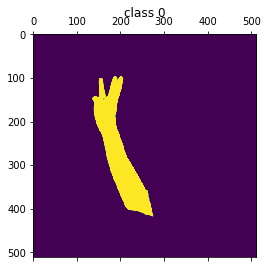

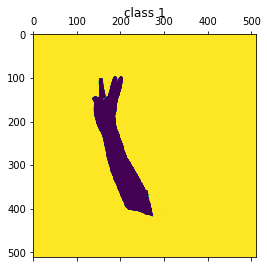

In [ ]:
import matplotlib.pyplot as plt
lab  = logits[0]
plt.matshow(np.squeeze(lab[[0]].permute(1, 2, 0).cpu()).detach().numpy())
plt.title("class 0")
plt.matshow(np.squeeze(lab[[1]].permute(1, 2, 0).cpu()).detach().numpy())
plt.title("class 1")

Text(0.5, 1.05, 'class 1')

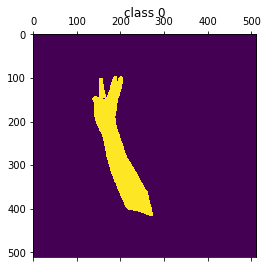

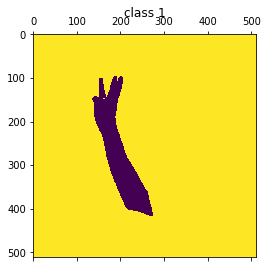

In [ ]:
import matplotlib.pyplot as plt
mas  = masks[0]
plt.matshow(np.squeeze(mas[[0]].permute(1, 2, 0).cpu()).detach().numpy())
plt.title("class 0")
plt.matshow(np.squeeze(mas[[1]].permute(1, 2, 0).cpu()).detach().numpy())
plt.title("class 1")

  ## KOMÓRKI PONIŻEJ NIE SĄ POTRZEBNE DO TESTÓW NA 2 DATASETACH

In [ ]:
mean = torch.tensor([48.1431, 47.4175, 42.4370], dtype=torch.float64)
std = torch.tensor([45.2122, 40.2552, 37.7503], dtype=torch.float64)

transform_label = transforms.Compose([transforms.ToTensor()])
transform_image = transforms.Compose([transforms.Normalize(mean, std)])

data_1 = SkinDataset("data_type1.csv", 512, transform_image, transform_label)
data_2a = SkinDataset("data_type2a.csv", 512, transform_image, transform_label)
data_2b = SkinDataset("data_type2b.csv", 512, transform_image, transform_label)
data_all = torch.utils.data.ConcatDataset([data_1, data_2a, data_2b])

In [ ]:
import numpy as np

train_percent = 0.8
train_len_1 = int(np.floor(train_percent * len(data_1)))
train_len_2a = int(np.floor(train_percent * len(data_2a)))
train_len_2b = int(np.floor(train_percent * len(data_2b)))

train_1, test_1 = torch.utils.data.random_split(data_1, [train_len_1, len(data_1) - train_len_1], generator=torch.Generator().manual_seed(42))
train_2a, test_2a = torch.utils.data.random_split(data_2a, [train_len_2a, len(data_2a) - train_len_2a], generator=torch.Generator().manual_seed(42))
train_2b, test_2b = torch.utils.data.random_split(data_2b, [train_len_2b, len(data_2b) - train_len_2b], generator=torch.Generator().manual_seed(42))

data_train_val = torch.utils.data.ConcatDataset([train_1, train_2a, train_2b])
data_test = torch.utils.data.ConcatDataset([test_1, test_2a, test_2b])


val_percent = 0.15
val_len = int(np.floor(val_percent * len(data_train_val)))
data_train, data_val = torch.utils.data.random_split(data_train_val, 
                                                     [len(data_train_val) - val_len, val_len], 
                                                     generator=torch.Generator().manual_seed(42))